### Package imports

In [1]:
# Import packages
import re
import os
import copy
from pathlib import Path
import numpy as np
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
import pandas as pd
import random
import datetime
import time
from pdb import set_trace
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import BayesianGaussianMixture
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import gc

### Define Set

In [2]:
Set = 'Single' # Single means 'Protein' or 'mRNA' or Dual means 'Protein + mRNA'
#Set = 'Dual'

### Set seed function

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    rs = RandomState(MT19937(SeedSequence(seed)))

### File path

In [4]:
# File path
raw_data_path = '/home/ec2-user/MLNotebook shared/Datasets/Test set raw data/' # for Johansson and Mertins raw data, 
dataset_folder_path = '/home/ec2-user/MLNotebook shared/Datasets/' # for localization label
output_path = '/home/ec2-user/MLNotebook shared/Datasets/'

### Functions

In [5]:
def Gaussian_KDE(df1, df2, Set, Canvas_Size):
    """
    Function to generate synthetic data using Gaussian KDE.
    Args:
        df1: DataFrame 1 (e.g., Protein/mRNA abundance for Single set)
        df2: DataFrame 2 (e.g., mRNA abundance for Dual set, optional)
        Set: 'Single' or 'Dual', determines the modeling approach
        Canvas_Size: Target size for the final dataset (rows x columns)
    Returns:
        final_df: Original data with synthetic data appended
    """
    # Placeholder for synthetic data
    synthetic_data = []

    # Transpose the DataFrames for easier column-wise processing
    df1 = df1.T
    df2 = df2.T if df2 is not None else None

    if Set == 'Single':
        for _ in range(int(Canvas_Size * Canvas_Size - df1.index.size)):
            synthetic_row = []
            for col in df1.columns:
                # Fit KDE to the abundance values (univariate KDE)
                kde = gaussian_kde(df1[col], bw_method='silverman')
                # Sample from the fitted KDE
                synthetic_row.append(kde.resample(1)[0][0])
            synthetic_data.append(synthetic_row)

    elif Set == 'Dual':
        for _ in range(int((Canvas_Size * Canvas_Size - df1.index.size * 2) / 2)):
            synthetic_row = []
            for col1, col2 in zip(df1.columns, df2.columns):
                # Get the abundance values for the joint distribution
                x = df1[col1].values
                y = df2[col2].values
                
                # Combine x and y for joint KDE
                data = np.vstack([x, y])
                
                # Fit a joint KDE
                kde = gaussian_kde(data, bw_method='silverman')
                
                # Sample from the joint KDE
                sample = kde.resample(1)
                sampled_x, sampled_y = sample[0][0], sample[1][0]
                
                # Add sampled values to the synthetic row
                synthetic_row.append(sampled_x)  # For df1 (e.g., protein)
                synthetic_row.append(sampled_y)  # For df2 (e.g., mRNA)
            
            synthetic_data.append(synthetic_row)

    # Convert synthetic data to a new DataFrame
    print('Synthetic data generated')
    if Set == 'Single':
        synthetic_df = pd.DataFrame(synthetic_data, columns=df1.columns)
        final_df = pd.concat([df1, synthetic_df], axis=0)
    elif Set == 'Dual':
        # For Dual, split the synthetic data into two parts
        synthetic_df1 = pd.DataFrame([row[::2] for row in synthetic_data], columns=df1.columns)
        synthetic_df2 = pd.DataFrame([row[1::2] for row in synthetic_data], columns=df2.columns)
        # Combine synthetic with original
        final_df1 = pd.concat([df1, synthetic_df1], axis=0)
        final_df2 = pd.concat([df2, synthetic_df2], axis=0)

    # Transpose the DataFrame(s) back to original orientation
    if Set == 'Single':
        final_df = final_df.T
    
        return final_df

    elif Set == 'Dual':
        final_df1 = final_df1.T
        final_df2 = final_df2.T

        return final_df1, final_df2

In [6]:
# Not used, but kept for reference

# def Bayesian_GMM(PD, MD, Set, Rand_State_1, Rand_State_2, Canvas_Size):

#     if Set == 'Protein' or Set == 'Protein + mRNA':
#         # Fit the dataset to Bayesian Gaussian Mixture Model
#         PD_T = PD.T
#         PD_bgm = BayesianGaussianMixture(n_components=2, random_state=Rand_State_1) # mean_prior=PD_T.mean(axis=0)
#         PD_bgm.fit(PD_T)

#         # Get the non-zero weights
#         used_components = (PD_bgm.weights_ > 1e-3).sum()

#         print(f'Number of used components: {used_components}')
#         # Generate X new synthetic tumors, result is an array
#         if Set == 'Protein':
#             synthetic_PD, _ = PD_bgm.sample(int(Canvas_Size*Canvas_Size-PD.columns.size))
#         elif Set == 'Protein + mRNA':
#             synthetic_PD, _ = PD_bgm.sample(int((Canvas_Size*Canvas_Size-PD.columns.size*2)/2))
    
#         # Transpose back before merging
#         synthetic_PD = synthetic_PD.T

#         # Convert the result to a DataFrame
#         synthetic_PD = pd.DataFrame(synthetic_PD.tolist(), index=PD.index)

#         # Merge the synthetic data with the original data
#         PD = pd.concat([PD, synthetic_PD], axis=1)

#         # Sanity check for the number of tumors in each dataframe
        
#         if Set == 'Protein + mRNA':
#             assert len(PD.columns) == Canvas_Size*Canvas_Size // 2
#         else:
#             assert len(PD.columns) == Canvas_Size*Canvas_Size

#         print(f'{Set} - Post-Bayesian PD: {len(PD.columns)}')
      
#     if Set == 'mRNA' or Set == 'Protein + mRNA':
#         # Fit the dataset to Bayesian Gaussian Mixture Mode
#         MD_T = MD.T
#         MD_bgm = BayesianGaussianMixture(n_components=2, mean_prior=MD_T.mean(axis=0), random_state=Rand_State_2)
#         MD_bgm.fit(MD_T)

#         # Generate X new synthetic tumors, result is an array
#         if Set == 'mRNA':
#             synthetic_MD, _ = MD_bgm.sample(int(Canvas_Size*Canvas_Size-MD.columns.size))
#         if Set == 'Protein + mRNA':
#             synthetic_MD, _ = MD_bgm.sample(int((Canvas_Size*Canvas_Size-MD.columns.size*2)/2))

#         # Get the non-zero weights
#         used_components = (MD_bgm.weights_ > 1e-3).sum()

#         print(f'Number of used components: {used_components}')

#         # Transpose back before merging
#         synthetic_MD = synthetic_MD.T

#         # Convert the result to a DataFrame
#         synthetic_MD = pd.DataFrame(synthetic_MD.tolist(), index=MD.index)

#         # Merge the synthetic data with the original data
#         MD = pd.concat([MD, synthetic_MD], axis=1)
         
#         # Sanity check for the number of tumors in each dataframe
#         if Set == 'Protein + mRNA':
#             assert len(MD.columns) == Canvas_Size*Canvas_Size // 2
#         else:
#             assert len(MD.columns) == Canvas_Size*Canvas_Size
#         print(f'{Set} - Post Bayesian MD: {len(MD.columns)}')

#     else:
#         print('No synthetic data generated')
    
#     return PD, MD

In [7]:
def NormalizeProt(df):
    # Unlog the data
    df = 2**df

    # Normalize by gene average for each row
    df = df.divide(df.mean(axis=1), axis=0)

    # Normalize by tumor median for each column
    df = df.divide(df.median(axis=0), axis=1)

    # Log2 transform
    df = np.log2(df)

    # Standarize by gene std for each row
    df = df.divide(df.std(axis=1), axis=0)

    # # Find the 2.5th and 97.5th percentile value globally
    # lower_bound = np.percentile(df.values, 2.5)
    # upper_bound = np.percentile(df.values, 97.5)

    # # Normalize using the global percentile values
    # df = (df)/(upper_bound-lower_bound)

    return df

In [8]:
def NormalizeRNA(df):
    # Unlog the data
    df = 2**df

    # Normalize by gene average for each row
    df = df.divide(df.mean(axis=1), axis=0)

    # Normalize by tumor median for each column
    df = df.divide(df.median(axis=0), axis=1)

    # Log2 transform
    df = np.log2(df)

    # Standarize by gene std for each row
    df = df.divide(df.std(axis=1), axis=0)

    # # Find the 2.5th and 97.5th percentile value globally
    # lower_bound = np.percentile(df.values, 2.5)
    # upper_bound = np.percentile(df.values, 97.5)

    # # Normalize using the global percentile values
    # df = (df)/(upper_bound-lower_bound)

    return df

In [9]:
def VisualizeData(PD, MD):
    # Create a figure
    plt.figure(figsize=(12, 12))

    # Create a subplot for PD boxplot
    plt.subplot(2, 2, 1)
    plt.boxplot(PD.values)
    plt.title('Proteome')
    plt.xlabel('Tumors')
    plt.ylabel('Abundances')
    plt.xticks([])

    # Create a subplot for MD boxplot
    plt.subplot(2, 2, 2)
    plt.boxplot(MD.values)
    plt.title('Transcriptome')
    plt.xlabel('Tumors')
    plt.ylabel('Abundances')
    plt.xticks([])

    # Create a subplot for PD histogram
    plt.subplot(2, 2, 3)
    plt.hist(PD.values.flatten(), bins=500)
    plt.title('Proteome')
    plt.xlabel('Tumors')
    plt.ylabel('Count')

    # Create a subplot for MD histogram
    plt.subplot(2, 2, 4)
    plt.hist(MD.values.flatten(), bins=500)
    plt.title('Transcriptome')
    plt.xlabel('Tumors')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

### Preparing data for Krug

#### Raw data proceesing

In [10]:
# Open the proteomics data and only keep genes (rows) that are fully quantified
#PFP = 'kr_pro_raw copy.csv' # tumor standardized with mean and std, 2-component Gaussian mixture model-based normalization for gene
#PFP = 'kr_pro_raw.csv' # LethioDDA search: proteomics file (genes table) path, normalized by pool, log2 transformed.
PFP = 'krug prot model use.csv' # MSFragger search, abundances are ratio of channel to pool, no transformation
PD = pd.read_csv(raw_data_path+PFP)

# Indexing and remove NA
PD.index = PD.loc[:,'Index']
PD = PD.loc[:,PD.columns!='Index'] # Shape (12372, 135)
PD.dropna(inplace=True) # Shape (8481, 135)

# Remove tumors that contain keyword 'notinstudy': 3 tumors are not in the study
PD = PD.loc[:,~PD.columns.str.contains('notinstudy')]

# Remove tumors that contain keyword 'Retro': 2 tumors are RetroIR
PD = PD.loc[:,~PD.columns.str.contains('Retro')]

# Find tumors that contain keyword 'REP'
rep_cols = PD.columns[PD.columns.str.contains('REP')]

# Extract tumors' name that has replicates
rep_tumors = set(col.split('.')[0] for col in rep_cols)

# Find columns that match the names in rep_tumors, take average and save it under the tumor name that without REP
for rep_tumor in rep_tumors:
    replicates = PD.columns[PD.columns.str.contains(rep_tumor)]
    PD[rep_tumor] = PD[replicates].mean(axis=1) # Overwrite the original tumor with the average of the replicates
    # Drop the REP column of the rep_tumor only
    replicate_cols = PD.columns[PD.columns.str.contains(rep_tumor+'.REP')]
    PD.drop(replicate_cols, axis=1, inplace=True) # Drop the replicate columns

# Drop tumor X03BR011 because it has no mRNA data
PD.drop('X03BR011', axis=1, inplace=True)

# Log2 transform the data ************IMPORTANT CHANGE*****************
PD = np.log2(PD)

# Sort the column names in the dataframe
PD = PD.reindex(sorted(PD.columns), axis=1) # Shape (8481, 121)

In [11]:
# Open the mRNA data and only keep genes (rows) that are fully quantified
#MFP = 'kr_rna_raw.csv' # mRNA file path, log2 transformed
MFP = 'krug mrna model use.csv' # TPM data, untransformed
MD = pd.read_csv(raw_data_path+MFP)

# Data set wrangling
MD.index = MD.loc[:,'Index']
MD = MD.loc[:,MD.columns!='Index'] # Shape (19938, 121)
MD.dropna(inplace=True) # Shape (19938, 121)

# Drop if any gene that contains 0 read of TPM
MD = MD.loc[~(MD==0).any(axis=1)] # Shape (13627, 121)

# Log2 transform the data ************IMPORTANT CHANGE*****************
MD = np.log2(MD)

# Sort the column names in the dataframe
MD = MD.reindex(sorted(MD.columns), axis=1) # Shape (13627, 121)

#### Normalization

In [12]:
# Visualize the processed data with boxplot and histogram
PD_norm = NormalizeProt(PD)
MD_norm = NormalizeRNA(MD)

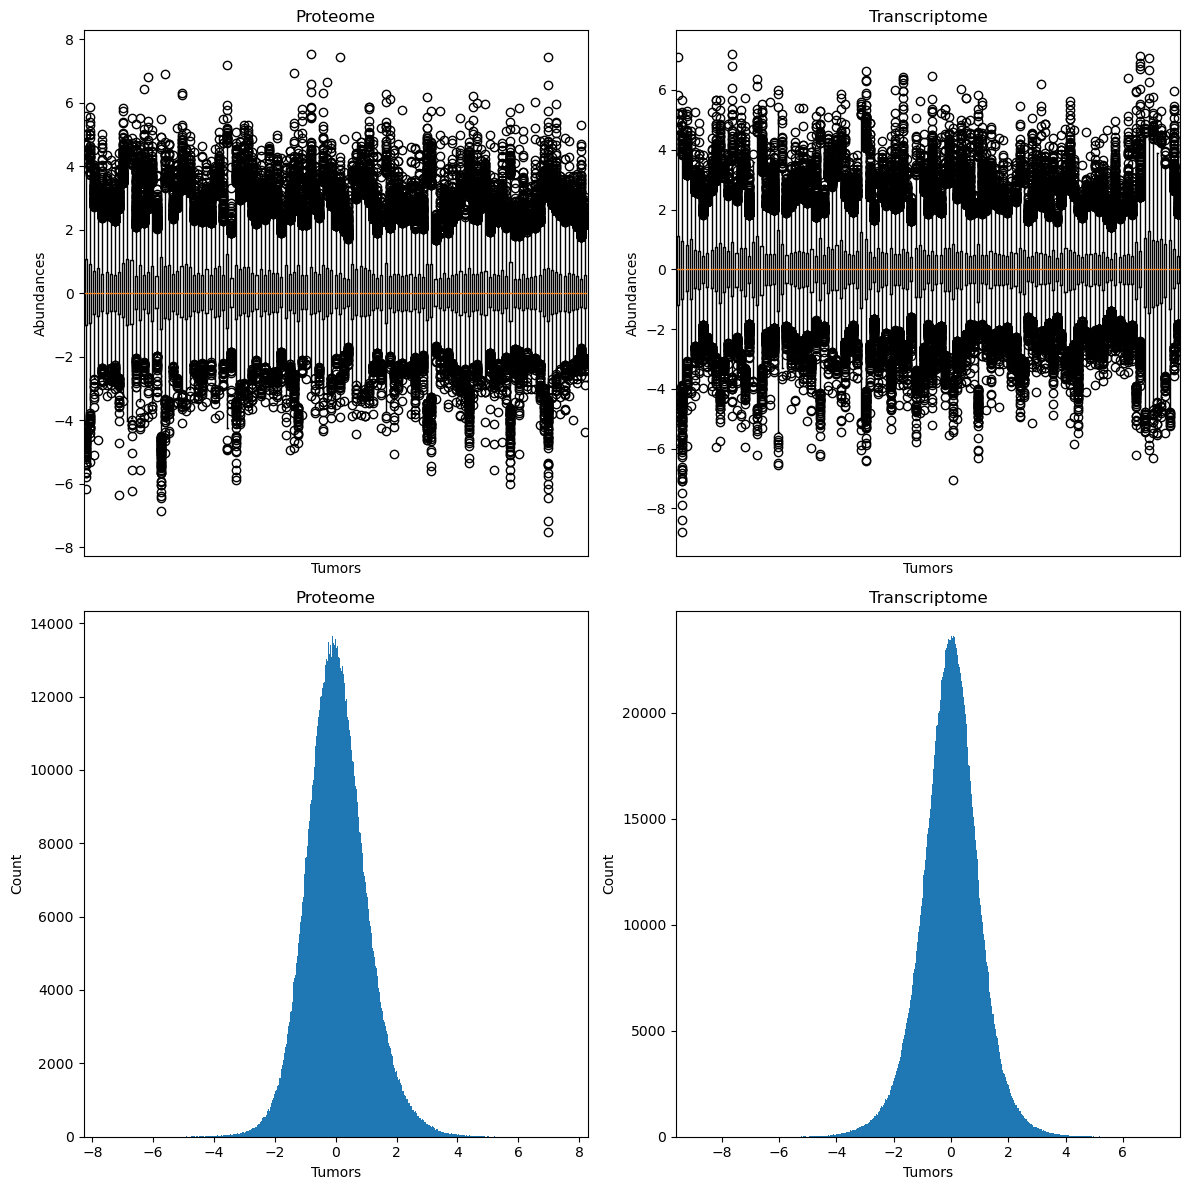

In [13]:
VisualizeData(PD_norm, MD_norm)

#### Filter out genes that has labels

In [14]:
# Open the labels data
#LFP = 'SubCellBarcode.MCF7.txt'
LFP = 'markers.txt'
LD = pd.read_csv(filepath_or_buffer=dataset_folder_path+LFP,sep='\t')

# Data set wrangling
LD.index = LD.loc[:,'Protein']
LD = LD.loc[:,LD.columns!='Protein']

# Remove unclassified class
NotUnclassInd = LD.loc[:,'Localization'] != 'Unclassified'
LD = LD.loc[NotUnclassInd,:]

In [15]:
# Keep only genes (rows) are presented in proteome, mRNA and localization data sets
IntersectingGenes = [value for value in PD_norm.index if ((value in MD_norm.index) & (value in LD.index))]
PD_norm = PD_norm.loc[IntersectingGenes,:]
MD_norm = MD_norm.loc[IntersectingGenes,:]
LD = LD.loc[IntersectingGenes,:]

# Sanity check for the number of genes in each dataframe
print('Krug')
print(len(PD_norm.index))
print(len(MD_norm.index))
print(len(LD.index))

Krug
2693
2693
2693


#### Inferencing

In [16]:
# Ensure reproducibility
set_seed(43)

# Generate synthetic data using Bayesian Gaussian Mixture Model
# PD_syn, MD_syn = Bayesian_GMM(PD=PD_norm, MD=MD_norm, Set=Set, Rand_State_1=42, Rand_State_2=43, Canvas_Size=18)

# Synthetic tumors using gaussian KDE
if Set == 'Single':
    PD_norm = Gaussian_KDE(PD_norm, None, Set, 18)
    MD_norm = Gaussian_KDE(MD_norm, None, Set, 18)
elif Set == 'Dual':
    PD_norm, MD_norm = Gaussian_KDE(PD_norm, MD_norm, Set, 18)

Synthetic data generated
Synthetic data generated


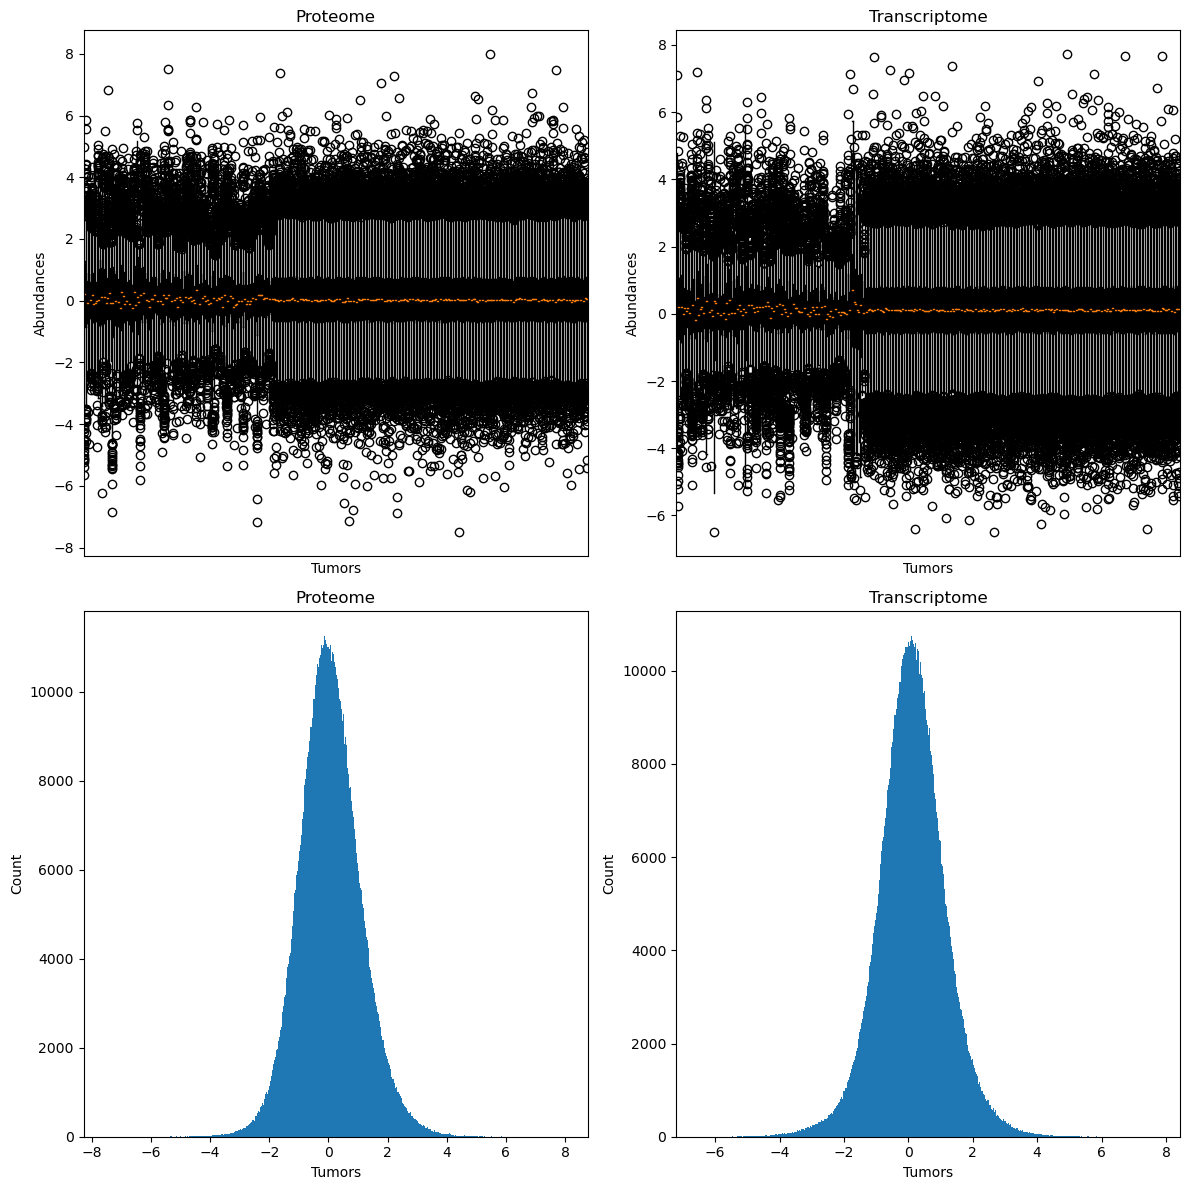

In [17]:
VisualizeData(PD_norm, MD_norm)

### Preparing data for Johansson

#### Raw data processing

In [18]:
# Johansson data set
# Open the proteomics data and only keep genes (rows) that are fully quantified
#J_PFP = 'jo_protein_log2.csv' # proteomics file path, normalized by pool, log2 transformed.
J_PFP = 'johansson prot model use.csv' # MSFragger search, abundances are ratio of channel to pool, no transformation
J_PD = pd.read_csv(raw_data_path+J_PFP)

# Sort the column names in the dataframe
J_PD = J_PD.reindex(sorted(J_PD.columns), axis=1)

# # Data set wrangling
J_PD.index = J_PD.loc[:,'Index']
J_PD = J_PD.loc[:,J_PD.columns!='Index'] # Shape (12811, 45)
J_PD.dropna(inplace=True) # Shape (10559, 45)

# Log2 transform the data ************IMPORTANT CHANGE*****************
J_PD = np.log2(J_PD)

# Open the mRNA data and only keep genes (rows) that are fully quantified
J_MFP = 'jo_mrna_dropna_newtumorid.csv' # mRNA file path, gene centric median normalized, log2 transformed
J_MD = pd.read_csv(raw_data_path + J_MFP)

# Sort the column names in both dataframe
J_MD = J_MD.reindex(sorted(J_MD.columns), axis=1)

# Data set wrangling
J_MD.index = J_MD.loc[:,'Unnamed: 0']
J_MD = J_MD.loc[:,J_MD.columns!='Unnamed: 0'] # Shape (32369, 45)
J_MD.dropna(inplace=True) # (32368, 45)

#### Nomarlization

In [19]:
J_PD_norm = NormalizeProt(J_PD)
J_MD_norm = NormalizeRNA(J_MD)

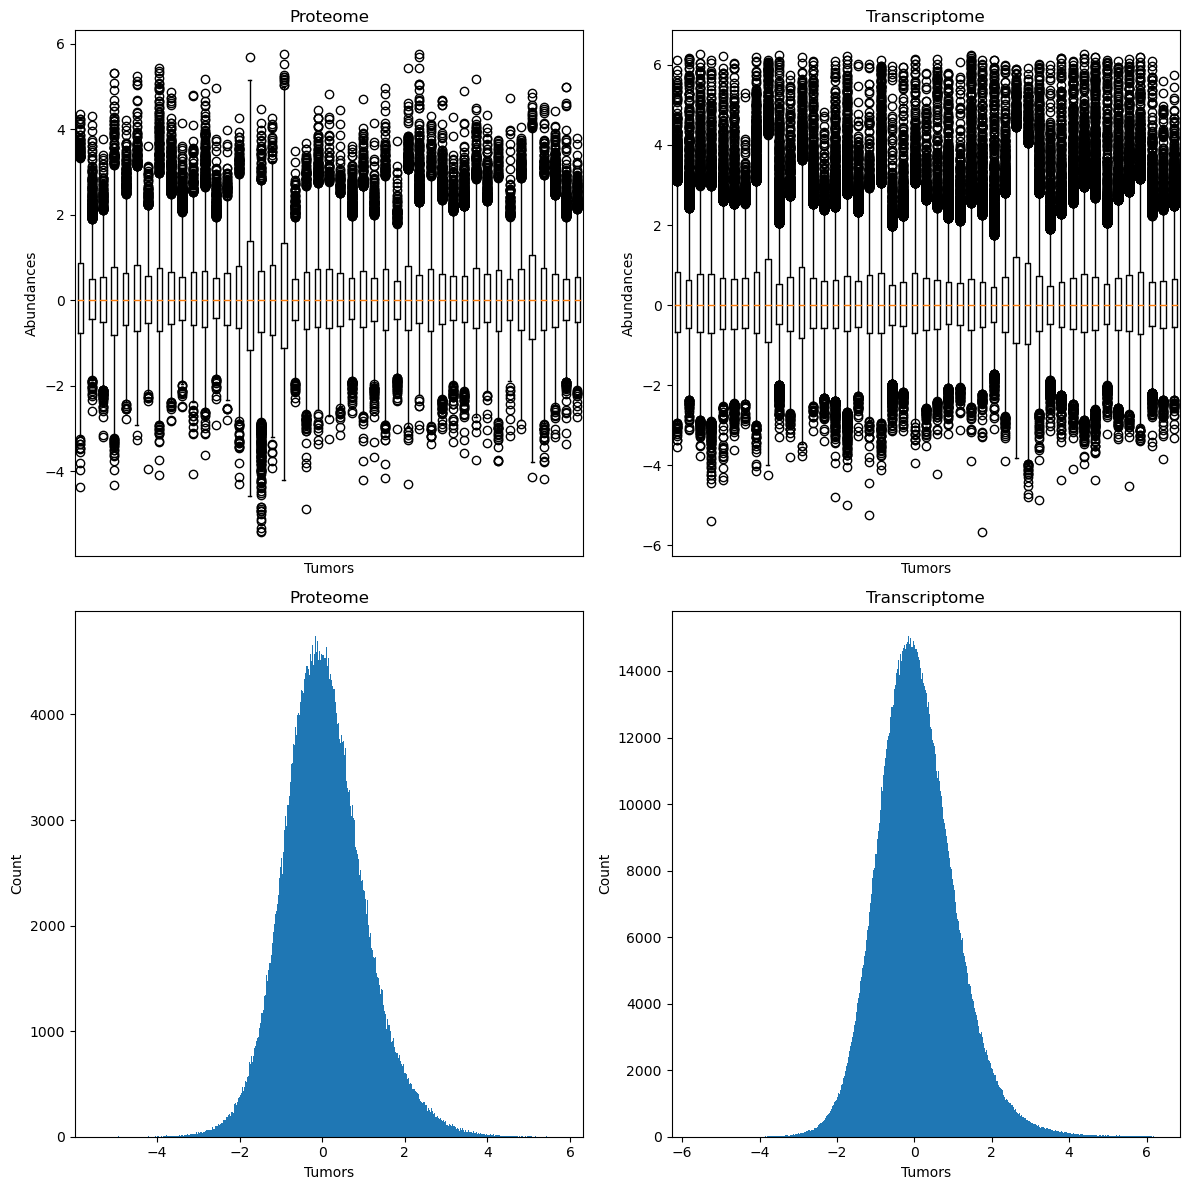

In [20]:
VisualizeData(J_PD_norm, J_MD_norm)

#### Filter out genes that has labels

In [21]:
# Open the labels data
#LFP = 'SubCellBarcode.MCF7.txt'
LFP = 'markers.txt'
LD = pd.read_csv(filepath_or_buffer=dataset_folder_path+LFP,sep='\t')

# Data set wrangling
LD.index = LD.loc[:,'Protein']
LD = LD.loc[:,LD.columns!='Protein']

# Remove unclassified class
NotUnclassInd = LD.loc[:,'Localization'] != 'Unclassified'
LD = LD.loc[NotUnclassInd,:]

In [22]:
# Keep only genes (rows) are presented in proteome, mRNA and localization data sets
IntersectingGenes = [value for value in J_PD_norm.index if ((value in J_MD_norm.index) & (value in LD.index))]
J_PD_norm = J_PD_norm.loc[IntersectingGenes,:]
J_MD_norm = J_MD_norm.loc[IntersectingGenes,:]
LD = LD.loc[IntersectingGenes,:]

# Sanity check for the number of genes in each dataframe
print('Johansson')
print(len(J_PD_norm.index))
print(len(J_MD_norm.index))
print(len(LD.index))

Johansson
3037
3037
3037


#### Inferencing

In [23]:
# Ensure reproducibility
set_seed(43)

# Generate synthetic data using Bayesian Gaussian Mixture Model
# PD_syn, MD_syn = Bayesian_GMM(PD=J_PD, MD=J_MD, Set=Set, Rand_State_1=42, Rand_State_2=43, Canvas_Size=18)

# Synthetic tumors using gaussian KDE
if Set == 'Single':
    J_PD_norm = Gaussian_KDE(J_PD_norm, None, Set, 18)
    J_MD_norm = Gaussian_KDE(J_MD_norm, None, Set, 18)
elif Set == 'Dual':
    J_PD_norm, J_MD_norm = Gaussian_KDE(J_PD_norm, J_MD_norm, Set, 18)

Synthetic data generated
Synthetic data generated


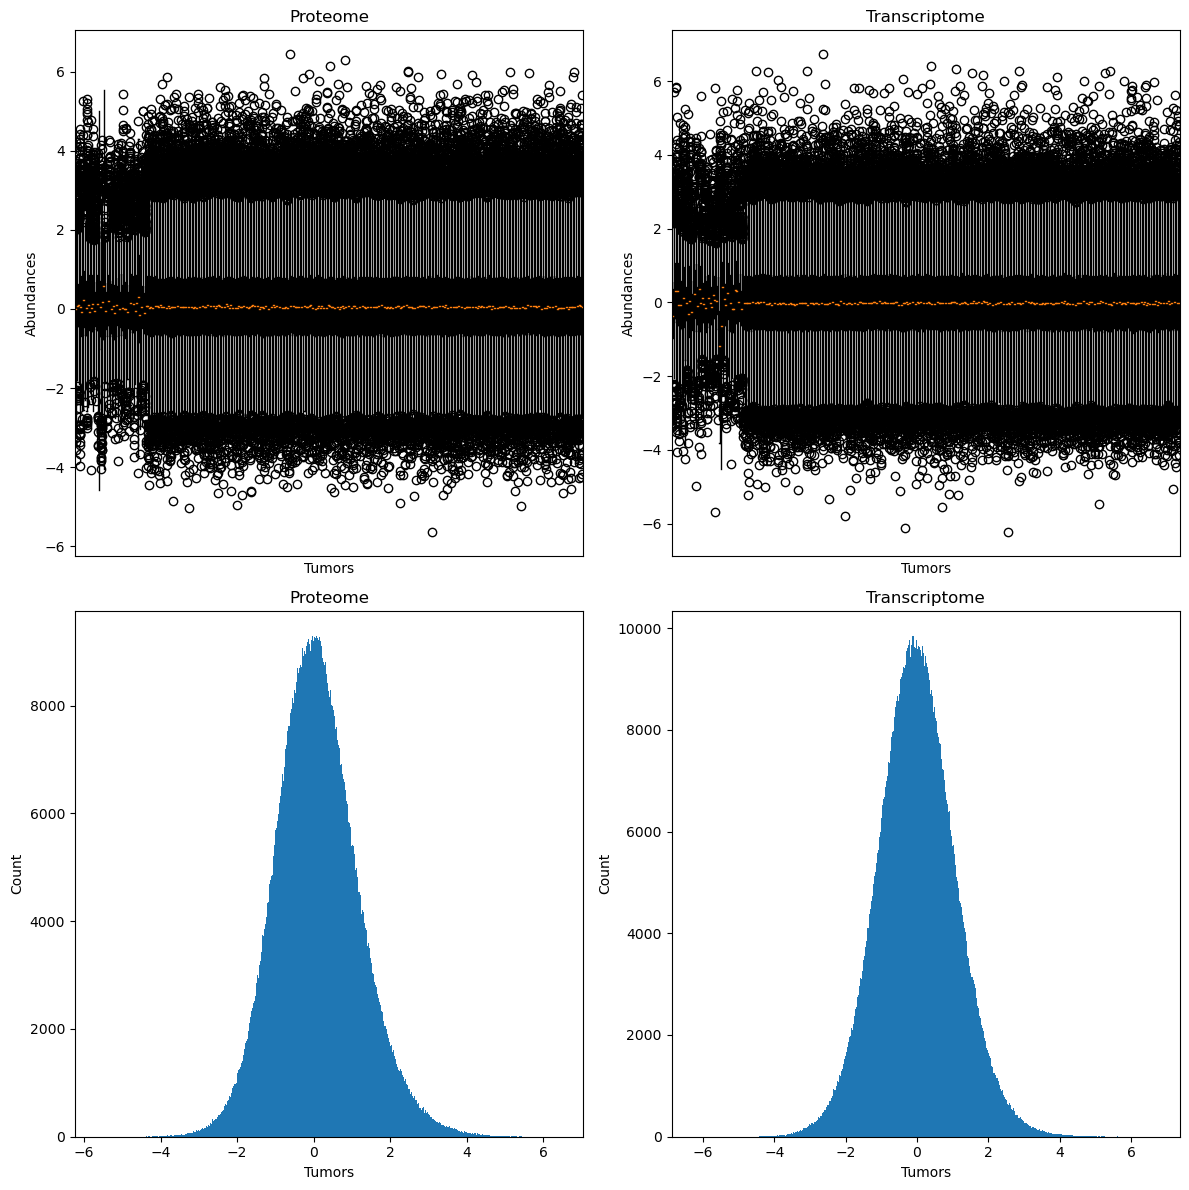

In [24]:
VisualizeData(J_PD_norm, J_MD_norm)

### Preparing data for Mertins

#### Raw data processing

In [25]:
# Mertins data set
# Open the proteomics data and only keep genes (rows) that are fully quantified
#M_PFP = 'me_protein_dropna.csv' # proteomics file path, normalized by pool, log2 transformed.
M_PFP = 'mertins prot model use.csv' # MSFragger search, abundances are ratio of channel to pool, no transformation
M_PD = pd.read_csv(raw_data_path+M_PFP)

# Data set wrangling
M_PD.index = M_PD.loc[:,'Index']
M_PD = M_PD.loc[:,M_PD.columns!='Index'] # Shape (12302, 111)
M_PD.dropna(inplace=True) # Shape (7064, 111)

# Remove tumors that contain keyword 'notinstudy': 28 tumors are not in the study
M_PD = M_PD.loc[:,~M_PD.columns.str.contains('notinstudy')]

# Find tumors that contain keyword 'REP'
M_PD_rep_cols = M_PD.columns[M_PD.columns.str.contains('REP')]

# Extract tumors' name that has replicates
M_PD_rep_tumors = set(col.split('.')[0] for col in M_PD_rep_cols)

# Find columns that match the names in rep_tumors, take average and save it under the tumor name that without REP
for M_PD_rep_tumor in M_PD_rep_tumors:
    M_PD_replicates = M_PD.columns[M_PD.columns.str.contains(M_PD_rep_tumor)]
    M_PD[M_PD_rep_tumor] = M_PD[M_PD_replicates].mean(axis=1) # Overwrite the original tumor with the average of the replicates
    # Drop the REP column of the rep_tumor only
    M_PD_replicate_cols = M_PD.columns[M_PD.columns.str.contains(M_PD_rep_tumor+'.REP')]
    M_PD.drop(M_PD_replicate_cols, axis=1, inplace=True) # Drop the replicate columns

# Log2 transform the data ************IMPORTANT CHANGE*****************
M_PD = np.log2(M_PD)

# Sort the column names in the dataframe
M_PD = M_PD.reindex(sorted(M_PD.columns), axis=1) # Shape (7064, 77)

In [26]:
# Open the mRNA data and only keep genes (rows) that are fully quantified
#M_MFP = 'me_rna_dropna.csv' # mRNA file path, gene centric median normalized, log2 transformed
M_MFP = 'mertins mrna model use.csv' # TPM data, untransformed
M_MD = pd.read_csv(raw_data_path+M_MFP)

# Data set wrangling
M_MD.index = M_MD.loc[:,'gene_name']
M_MD = M_MD.loc[:,M_MD.columns!='gene_name'] # Shape (19938, 77)

#M_MD = M_MD.drop_duplicates() # Shape (19292, 77)

M_MD.dropna(inplace=True) # Shape (19292, 77)

# Drop if any gene that contains 0 read of TPM (5063 genes are dropped, still have 6706 in common with PD)
M_MD = M_MD.loc[~(M_MD==0).any(axis=1)] # Shape (14229, 77)

# Log2 transform the data ************IMPORTANT CHANGE*****************
M_MD = np.log2(M_MD)

# Sort the column names in the dataframe
M_MD = M_MD.reindex(sorted(M_MD.columns), axis=1) # Shape (14229, 77)


#### Normalization

In [27]:
# Visualize the processed data with boxplot and histogram
M_PD_norm = NormalizeProt(M_PD)
M_MD_norm = NormalizeRNA(M_MD)

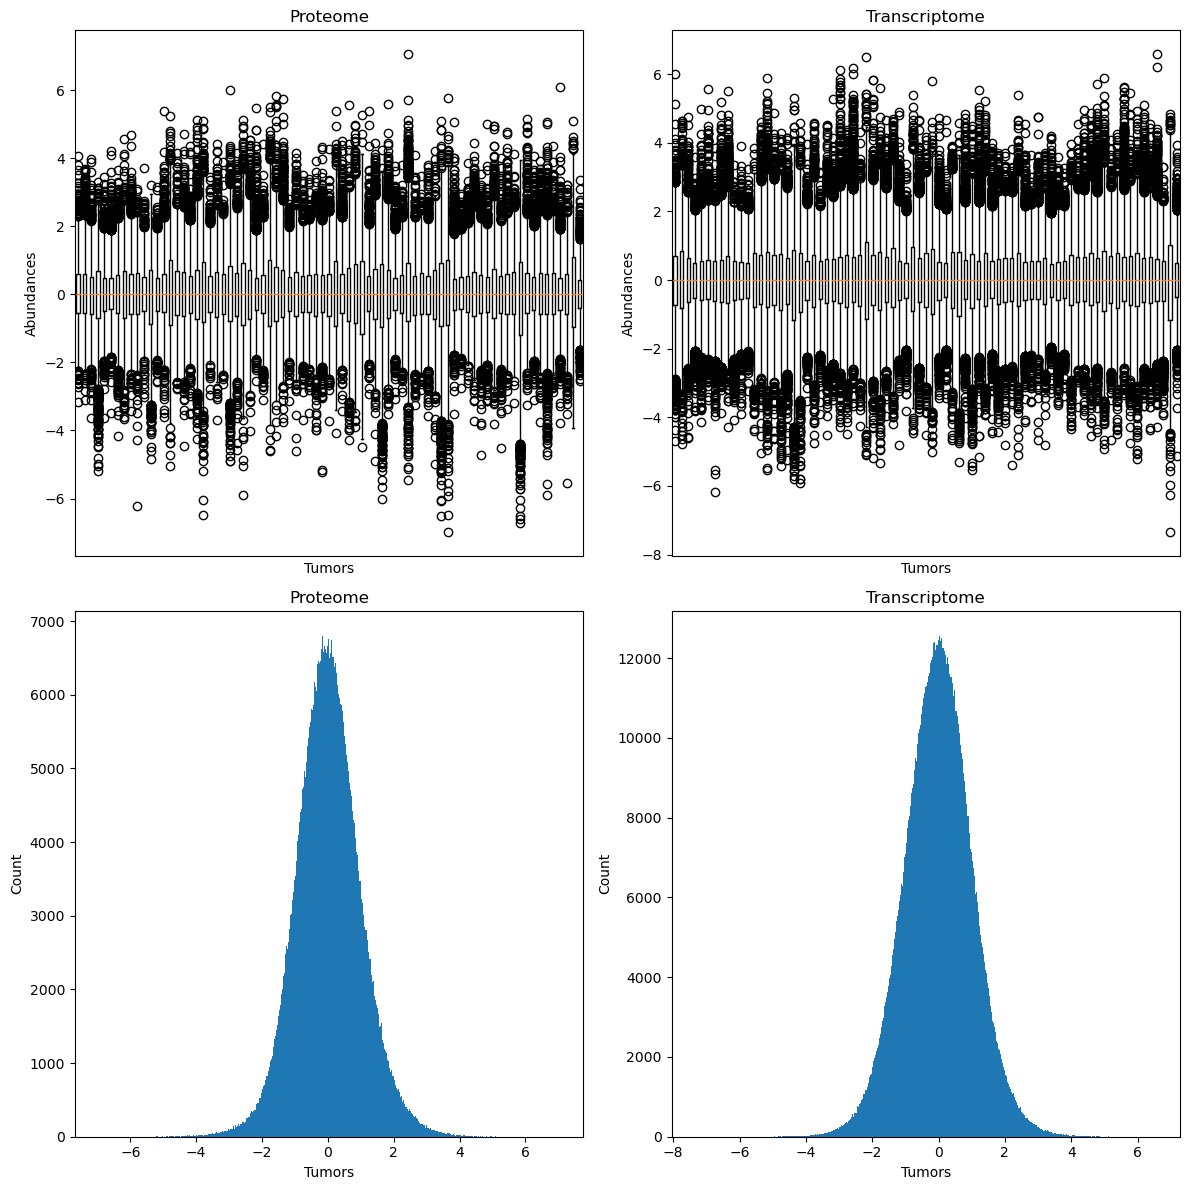

In [28]:
VisualizeData(M_PD_norm, M_MD_norm)

#### Filter out genes that has labels

In [29]:
# Open the labels data
#LFP = 'SubCellBarcode.MCF7.txt'
LFP = 'markers.txt'
LD = pd.read_csv(filepath_or_buffer=dataset_folder_path+LFP,sep='\t')

# Data set wrangling
LD.index = LD.loc[:,'Protein']
LD = LD.loc[:,LD.columns!='Protein']

# Remove unclassified class
NotUnclassInd = LD.loc[:,'Localization'] != 'Unclassified'
LD = LD.loc[NotUnclassInd,:]

In [30]:
# Keep only genes (rows) are presented in proteome, mRNA and localization data sets
IntersectingGenes = [value for value in M_PD_norm.index if ((value in M_MD_norm.index) & (value in LD.index))]
M_PD_norm = M_PD_norm.loc[IntersectingGenes,:]
M_MD_norm = M_MD_norm.loc[IntersectingGenes,:]
LD = LD.loc[IntersectingGenes,:]

# Sanity check for the number of genes in each dataframe
print('Mertin')
print(len(M_PD_norm.index))
print(len(M_MD_norm.index))
print(len(LD.index))

Mertin
2355
2355
2355


#### Inferencing

In [31]:
# Ensure reproducibility
set_seed(43)

# Generate synthetic data using Bayesian Gaussian Mixture Model
# PD_syn, MD_syn = Bayesian_GMM(PD=J_PD, MD=J_MD, Set=Set, Rand_State_1=42, Rand_State_2=43, Canvas_Size=18)

# Synthetic tumors using gaussian KDE
if Set == 'Single':
    M_PD_norm = Gaussian_KDE(M_PD_norm, None, Set, 18)
    M_MD_norm = Gaussian_KDE(M_MD_norm, None, Set, 18)
elif Set == 'Dual':
    M_PD_norm, M_MD_norm = Gaussian_KDE(M_PD_norm, M_MD_norm, Set, 18)

Synthetic data generated
Synthetic data generated


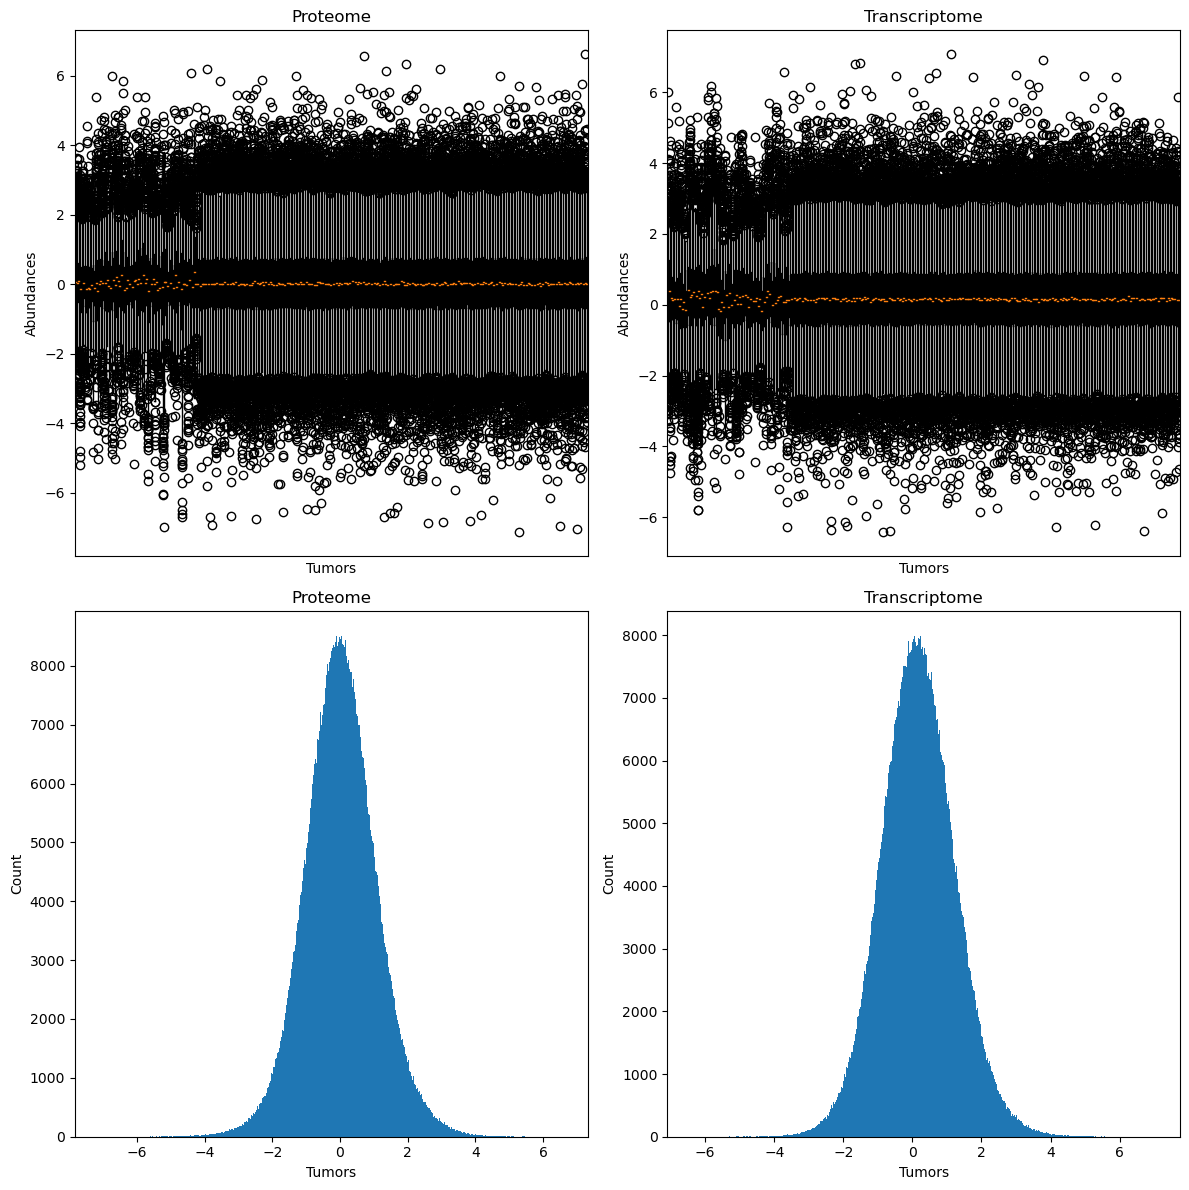

In [32]:
VisualizeData(M_PD_norm, M_MD_norm)

### Export

#### Johansson

In [33]:
# export the synthetic data
if Set == 'Single':
    J_PD_norm.to_csv(Path(output_path + 'J_single_PD_synthetic_kde_marker.csv'))
    J_MD_norm.to_csv(Path(output_path + 'J_single_MD_synthetic_kde_marker.csv'))
elif Set == 'Dual':
    J_PD_norm.to_csv(Path(output_path + 'J_dual_PD_synthetic_kde_marker.csv'))
    J_MD_norm.to_csv(Path(output_path + 'J_dual_MD_synthetic_kde_marker.csv'))

#### Krug

In [34]:
# Export
if Set == 'Single':
    PD_norm.to_csv(Path(output_path + 'K_single_PD_synthetic_kde_marker.csv'))
    MD_norm.to_csv(Path(output_path + 'K_single_MD_synthetic_kde_marker.csv'))
elif Set == 'Dual':
    PD_norm.to_csv(Path(output_path + 'K_dual_PD_synthetic_kde_marker.csv'))
    MD_norm.to_csv(Path(output_path + 'K_dual_MD_synthetic_kde_marker.csv'))

#### Mertins

In [35]:
# Export
if Set == 'Single':
    M_PD_norm.to_csv(Path(output_path + 'M_single_PD_synthetic_kde_marker.csv'))
    M_MD_norm.to_csv(Path(output_path + 'M_single_MD_synthetic_kde_marker.csv'))
elif Set == 'Dual':
    M_PD_norm.to_csv(Path(output_path + 'M_dual_PD_synthetic_kde_marker.csv'))
    M_MD_norm.to_csv(Path(output_path + 'M_dual_MD_synthetic_kde_marker.csv'))